# In-Painting Application

In this small project, the foreground/background of an image is automatically segmented and can be replaced by a generated image, conditioned by a text prompt.

- [SAM](#) is used as segmentation model.
- [Stable Diffusion XL Turbo](#) is used as in-painting model.
- [Gradio](#) is used as web UI engine.

As you can see, all models and tools come from [HuggingFace](#).

Here's an example:

TBD.

Table of contents:

- [Setup](#setup)
- [Zero-Shot Image Segmenation with SAM](#zero-shot-image-segmenation-with-sam)
- [In-Painting](#in-painting)

## Setup

In [1]:
from PIL import Image
import requests
from transformers import SamModel, SamProcessor
from diffusers import DiffusionPipeline, AutoPipelineForText2Image, AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid

import torch
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Name of each GPU
for i in range(torch.cuda.device_count()):
    print(i, torch.cuda.get_device_name(i))

0 NVIDIA GeForce RTX 3060
1 NVIDIA T500


In [4]:
# Select GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
!nvidia-smi

Sun Dec 14 15:48:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA T500                    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8            N/A  / 5001W |       5MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Zero-Shot Image Segmenation with SAM

[SAM](#) is ...

In [6]:
# Load SAM processor + model and move to GPU
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
sam_model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)

In [7]:
def mask_to_rgba(mask: np.ndarray) -> np.ndarray:
    """Transform a binary mask into an RGBA image for visualization."""
    bg_transparent = np.zeros(mask.shape + (4, ), dtype=np.uint8)    
    # Color the area we will replace in green
    # (this vector is [Red, Green, Blue, Alpha])
    bg_transparent[mask == 1] = [0, 255, 0, 127]

    return bg_transparent


def run_segmentation(
    image: np.ndarray,
    input_points: np.ndarray,
    processor: SamProcessor,
    model: SamModel,
    background: bool = True,
    device: str | torch.device = "cuda:0",
) -> np.ndarray:
    """
    Run SAM segmentation and return the best mask.

    Args:
        image (np.ndarray): The input image as a NumPy array.
        input_points (np.ndarray): The input points for SAM.
        processor (SamProcessor): The SAM processor.
        model (SamModel): The SAM model.
        background (bool): Whether to mask for background or foreground.
        device: str | torch.device = "cuda:0", 
            The device to run the model on.

    Returns:
        np.ndarray: The best mask as a NumPy array.
    """
    if isinstance(device, str):
        device = torch.device(device)
    model.to(device)
    
    # Prepare inputs
    inputs = processor(
        images=image,
        input_points=input_points,
        return_tensors="pt"
    ).to(device)

    # Run model
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Post-process the outputs of SAM to obtain the masks
    masks = processor.image_processor.post_process_masks(
       outputs.pred_masks.cpu(), 
       inputs["original_sizes"].cpu(), 
       inputs["reshaped_input_sizes"].cpu()
    )
    
    # Select the mask with the highest score
    best_mask = masks[0][0][outputs.iou_scores.argmax()] 

    # Invert the mask if we want to mask the background:
    # subject pixels will have a value of 0 
    # and the background pixels a value of 1.
    return ~best_mask.cpu().numpy() if background else best_mask.cpu().numpy()

### Example

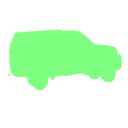

In [8]:
# Example image
raw_image = Image.open("./assets/car.png").convert("RGB").resize((512, 512))

# Coordinates of two points on the car
input_points = [[[150, 170], [300, 250]]]

# Run segmentation
mask = run_segmentation(raw_image, input_points, sam_processor, sam_model, background=False, device=device)

# Visualize the mask
Image.fromarray(mask_to_rgba(mask)).resize((128, 128))

## In-Painting

In [9]:
# Load the AutoPipelineForInpainting pipeline
inpainting_pipeline = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16,
)

# This will make it more efficient on our hardware
inpainting_pipeline.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [10]:
def run_inpainting(
    raw_image: Image.Image,
    input_mask: np.ndarray,
    prompt: str,
    pipeline: AutoPipelineForInpainting,
    negative_prompt: str = None,
    seed: int = 74294536,
    cfgs: int = 7,
):
    mask_image = Image.fromarray(input_mask)

    rand_gen = torch.manual_seed(seed)
    
    # Use the pipeline we have created in the previous cell
    # Use "prompt" as prompt, 
    # "negative_prompt" as the negative prompt,
    # raw_image as the image,
    # mask_image as the mask_image,
    # rand_gen as the generator and
    # cfgs as the guidance_scale
    image = pipeline(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=raw_image,
        mask_image=mask_image,
        generator=rand_gen,
        guidance_scale=cfgs,
    ).images[0]
    
    return image

In [11]:
image_inpainted = run_inpainting(
    raw_image=raw_image,
    input_mask=mask,
    prompt="A hummer parked on the street, photorealistic",
    pipeline=inpainting_pipeline,
)


  0%|          | 0/49 [00:00<?, ?it/s]

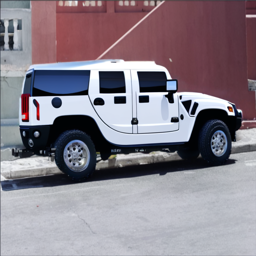

In [12]:
image_inpainted.resize((256, 256))

## Interactive Application

In [13]:
import app

In [14]:
def get_processed_inputs_wrapped(image_pil, points_list):
    image_np = np.array(image_pil)
    points_np = np.array(points_list, dtype=np.float32)
    return run_segmentation(
        image=image_np,
        input_points=points_np,
        processor=sam_processor,
        model=sam_model,
        background=True,
        device=device,
    )

def inpaint_wrapper(raw_image_pil, input_mask_np, prompt, negative_prompt, seed, cfgs):
    return run_inpainting(
        raw_image=raw_image_pil,
        input_mask=input_mask_np,
        prompt=prompt,
        pipeline=inpainting_pipeline,
        negative_prompt=negative_prompt,
        seed=seed,
        cfgs=cfgs,
    )

In [15]:
my_app = app.generate_app(get_processed_inputs_wrapped, inpaint_wrapper)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://74781b5351a098a532.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://74781b5351a098a532.gradio.live
